# Сборный проект "Поиск по изображениям"

## Описание проекта

Работа ведется в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).
<br> Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. <br>Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.
<br> Отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое: A man is crossing a mountain pass on a metal bridge и система выдает картинку согласно описанию.

### Юридические ограничения
В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.
<br>В сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:
<br>⎢ This image is unavailable in your country in compliance with local laws.
<br>Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента.
<br>Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

##Цель проекта

Целью проекта является разработка демонстрационной версии поиска изображений по запросу.
<br>Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.
<br>Таким образом, моделью решается регриссионная задача.

##Описание данных

В файле train_dataset.csv находится информация, необходимая для обучения:
- имя файла изображения,
- идентификатор описания и
- текст описания.
<br>Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
<br>В папке train_images содержатся изображения для тренировки модели.
<br>В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга.
<br>Номера колонок и соответствующий тип данных:
* Имя файла изображения.
* Идентификатор описания.
* Доля людей, подтвердивших, что описание соответствует изображению.
* Количество человек, подтвердивших, что описание соответствует изображению.
* Количество человек, подтвердивших, что описание не соответствует изображению.
<br>В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
* Имя файла изображения.
* Идентификатор описания.
* 3, 4, 5 — оценки трёх экспертов.
<br>Эксперты ставят оценки по шкале от 1 до 4, где:
* 1 — изображение и запрос совершенно не соответствуют друг другу,
* 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,
* 3 — запрос и текст соответствуют с точностью до некоторых деталей,
* 4 — запрос и текст соответствуют полностью.      
<br>В файле test_queries.csv находится информация, необходимая для тестирования:
- идентификатор запроса,
- текст запроса и
- релевантное изображение.
<br>Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
<br>В папке test_images содержатся изображения для тестирования модели.
При решении задачи используйте только один фреймворк  Pytorch или Keras.

#Блок импортов

In [ ]:
import os
import cv2
from math import ceil
from os import listdir
from os.path import isfile
import torch
import transformers
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms
#
from PIL import Image
#
#
#
#
import pandas as pd
import seaborn as sns
import numpy as np
#--------------sklearn----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                             root_mean_squared_error
                            )
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
#nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords, wordnet
#from pymystem3 import Mystem
import re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from tqdm import notebook, tqdm
tqdm.pandas()

plt.rcParams['font.size'] = 18.0
plt.rcParams.update({'axes.titlesize': 'large'})
sns.set_context(
                'notebook',
                rc={
                    'font.size': 15,
                    'axes.titlesize': 10,
                    'xtick.labelsize': 'small',
                    'ytick.labelsize': 'small',
                    'legend.fontsize': 'small',
                    'legend.title_fontsize': 10
                }
            )
sns.set (rc = {'figure.figsize':(5, 7)})
RANDOM_STATE = 2025
LETTERS = r'[^a-zA-Z\s]'
SPACES = r'([ ])\1+'

## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#/datasets/toxic_comments.csv
try:
    df_train = pd.read_csv('/content/drive/MyDrive/ds_project5/train_dataset.csv',)
    df_test_img = pd.read_csv('/content/drive/MyDrive/ds_project5/test_images.csv',)
    df_test_query = pd.read_csv('/content/drive/MyDrive/ds_project5/test_queries.csv', index_col=0, sep='|' )
    df_exp_annot = pd.read_csv('/content/drive/MyDrive/ExpertAnnotations.tsv', header=None, sep='\t')
    df_crwd_annot = pd.read_csv('/content/drive/MyDrive/CrowdAnnotations.tsv', header=None, sep='\t')
except:
    df_train = pd.read_csv('/content/drive/MyDrive/ds_project5/train_dataset.csv',)
    df_test_img = pd.read_csv('/content/drive/MyDrive/ds_project5/test_images.csv',)
    df_test_query = pd.read_csv('/content/drive/MyDrive/ds_project5/test_queries.csv',)
df_train.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [ ]:
df_test_img.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [ ]:
df_test_query.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [ ]:
df_exp_annot = df_exp_annot.rename(columns={0: 'image',
                                            1: 'query_id',
                                            2: 'grade1',
                                            3: 'grade2',
                                            4: 'grade3'})
df_exp_annot.head()

,image,query_id,grade1,grade2,grade3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [ ]:
df_crwd_annot = df_crwd_annot.rename(columns={
                                            0: 'image',
                                            1: 'query_id',
                                            2: 'match_rate',
                                            3: 'confirmed',
                                            4: 'rejected'})
df_crwd_annot.head()

,image,query_id,match_rate,confirmed,rejected
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Табличные данные успешно зачитаны, внесены первоначальные корректировки и можно приступать к исследованию данных.

## Исследовательский анализ данных

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [ ]:
df_train.duplicated().sum()

np.int64(0)

Пропусков и явных дубликатов в данных нет. Но в папке с картинками 1000 файлов, а не 5822 и в задании сказано, что для одной картинки может быть доступно до 5 описаний.

In [ ]:
len(df_train['image'].unique())

1000

Количество уникальных имен файлов совпадает с количеством файлов в папке. Для интереса можно убедиться, что имена файлов в папке совпадают с именами файлов в датасете.

In [ ]:
onlyfiles_train = listdir('/content/drive/MyDrive/ds_project5/train_images')
len(onlyfiles_train)

2002

In [ ]:
i = 0
for f in df_train['image'].unique():
    if f not in onlyfiles_train:
        print(f'Файла {f} нет в папке train.')
        i=+1
if i == 0:
    print('Все файлы на месте.')

Все файлы на месте.


### Анализ df_exp_annot

In [ ]:
df_exp_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   grade1    5822 non-null   int64 
 3   grade2    5822 non-null   int64 
 4   grade3    5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [ ]:
len(df_exp_annot['image'].unique())

1000

#### Визуализация числовых данных df_exp_annot

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

Выведу табличку с количеством оценок

In [ ]:
df_exp_annot.loc[:,['grade1', 'grade2','grade3']].value_counts()

grade1  grade2  grade3
1       1       1         2350
                2          965
        2       2          677
2       2       2          580
                3          307
4       4       4          247
3       3       3          214
2       3       3          191
1       2       3           98
3       3       4           72
        4       4           60
2       3       4           26
1       3       3           15
        1       3           12
2       4       4            3
1       2       4            2
2       2       4            2
1       4       4            1
Name: count, dtype: int64

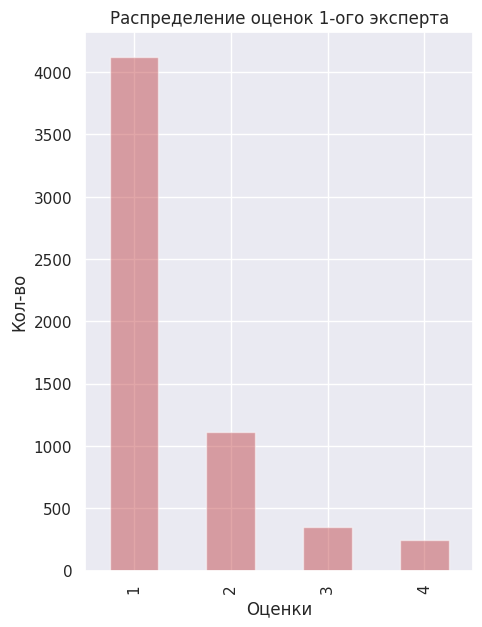

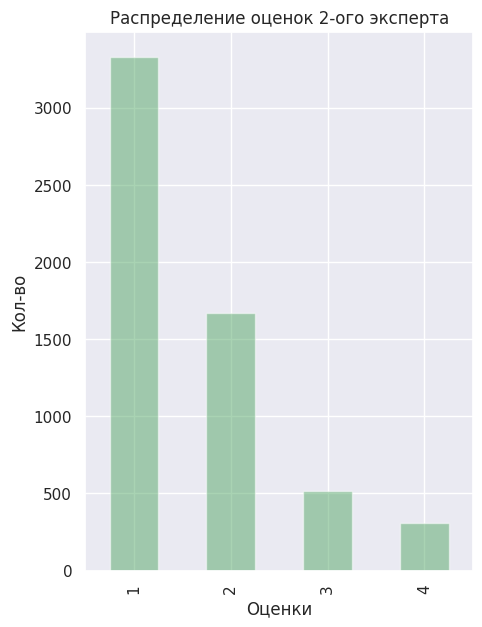

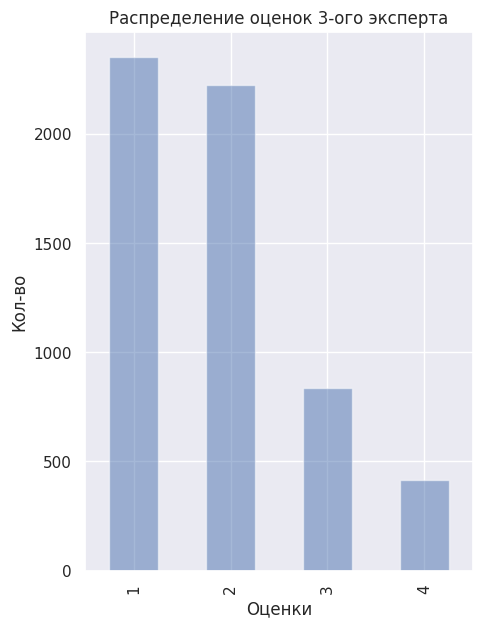

In [ ]:
color=['r', 'g', 'b']
for i in range(1, 4):
    col = 'grade'+ str(i)
    df_exp_annot[col].value_counts().plot(kind='bar',
                                           xlabel='Оценки',
                                           ylabel='Кол-во',
                                           color=color[i-1],
                                           alpha=0.5,
                                           #y=['grade1', 'grade2','grade3'],
                                           title=f'Распределение оценок {i}-ого эксперта'
                                           );
    plt.show();

### Анализ df_crwd_annot

In [ ]:
df_crwd_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       47830 non-null  object 
 1   query_id    47830 non-null  object 
 2   match_rate  47830 non-null  float64
 3   confirmed   47830 non-null  int64  
 4   rejected    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [ ]:
df_crwd_annot.duplicated().sum()

np.int64(0)

In [ ]:
len(df_crwd_annot['image'].unique())

1000

Проверка соответствия фотографий в выборках и датафрейме.

In [ ]:
i = 0
for elm in df_crwd_annot['image'].unique():
    if elm in df_train['image'].unique():
        continue
    else:
        i+=1
        print(f'Фото {elm} нет в обучающей выборке')
if i != 0:
    print(f'В вобучающей ыборке нет {i} фото из датафрейма df_crwd_annot')
else:
    print('Все фото представлены в обучающей выборке')

Все фото представлены в обучающей выборке


In [ ]:
i = 0
for elm in df_crwd_annot['image'].unique():
    if elm in df_test_query['image'].unique():
        continue
    else:
        i+=1
        print(f'Фото {elm} нет в тестовой выборке')
if i != 0:
    print(f'В тестовой выборке нет {i} фото')
else:
    print('Все фото представлены в тестовой выборке')

Фото 1056338697_4f7d7ce270.jpg нет в тестовой выборке
Фото 106490881_5a2dd9b7bd.jpg нет в тестовой выборке
Фото 1082379191_ec1e53f996.jpg нет в тестовой выборке
Фото 1084040636_97d9633581.jpg нет в тестовой выборке
Фото 1096395242_fc69f0ae5a.jpg нет в тестовой выборке
Фото 1107246521_d16a476380.jpg нет в тестовой выборке
Фото 1119015538_e8e796281e.jpg нет в тестовой выборке
Фото 1122944218_8eb3607403.jpg нет в тестовой выборке
Фото 1131800850_89c7ffd477.jpg нет в тестовой выборке
Фото 1131932671_c8d17751b3.jpg нет в тестовой выборке
Фото 113678030_87a6a6e42e.jpg нет в тестовой выборке
Фото 114051287_dd85625a04.jpg нет в тестовой выборке
Фото 115684808_cb01227802.jpg нет в тестовой выборке
Фото 1167669558_87a8a467d6.jpg нет в тестовой выборке
Фото 1174525839_7c1e6cfa86.jpg нет в тестовой выборке
Фото 1174629344_a2e1a2bdbf.jpg нет в тестовой выборке
Фото 1220401002_3f44b1f3f7.jpg нет в тестовой выборке
Фото 1224851143_33bcdd299c.jpg нет в тестовой выборке
Фото 1237985362_dbafc59280.jpg н

#### Визуализация числовых данных df_crwd_annot

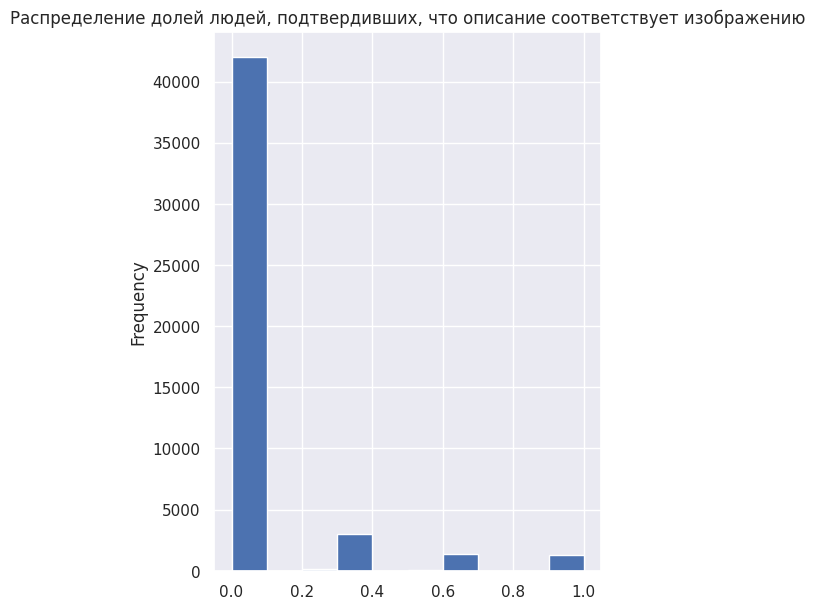

In [ ]:
df_crwd_annot['match_rate'].plot(
                                 kind='hist',
                                 bins=10,
                                 title='Распределение долей людей, подтвердивших, что описание соответствует изображению');

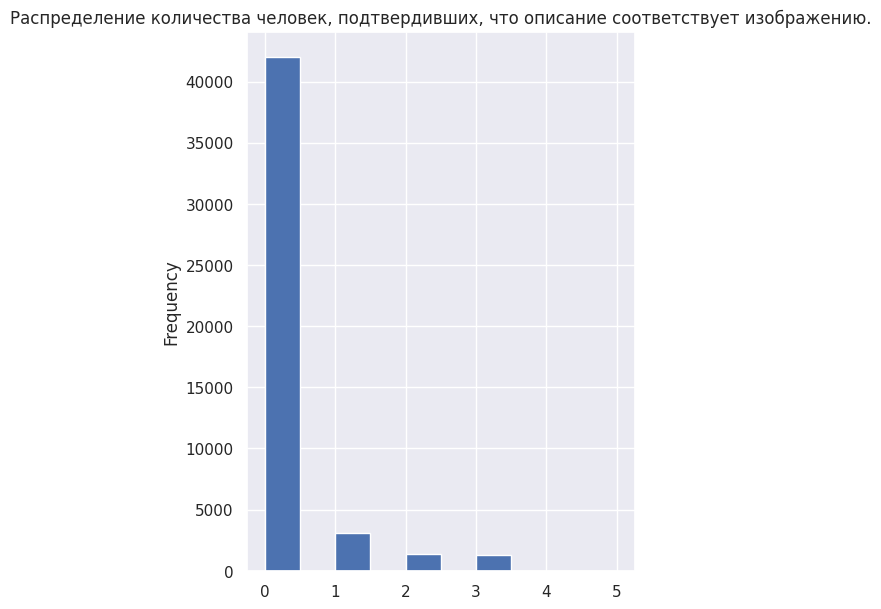

In [ ]:
df_crwd_annot['confirmed'].plot(
                                 kind='hist',
                                 bins=10,
                                 title='Распределение количества человек, подтвердивших, что описание соответствует изображению.');

Видно, что больше всего людей, не подтвердивших соответствие описагия изображению.

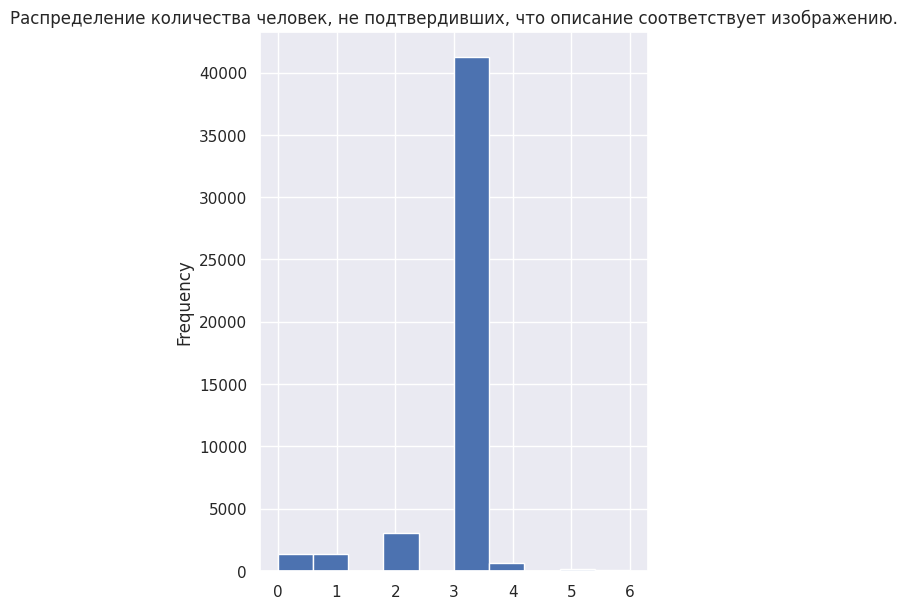

In [ ]:
df_crwd_annot['rejected'].plot(
                                 kind='hist',
                                 bins=10,
                                 title='Распределение количества человек, не подтвердивших, что описание соответствует изображению.');

Есть изображения, где все люди подтвердили соответствие описанию, но свыше 40000 случаев, когда 3 человека не подтвердили соответствие. Назревает вопрос о кондиционности данных.

### Тестовая выборка

In [ ]:
df_test_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


In [ ]:
df_test_img.duplicated().sum()

np.int64(0)

In [ ]:
df_test_query.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [ ]:
df_test_query.duplicated().sum()

np.int64(0)

## Учет юридических ограничений

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

In [ ]:
stop_list = [
    'child',
    'kid',
    'baby',
    'infant',
    'teenager',
    'youngster',
    'boy',
    'girl'
]

# Подготовка данных к обучению

## Векторизация текстового описания

Для проверки данных по стоплисту нужно лемматизировать текст описания.

In [ ]:
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    #
def lemmatize(text):
    # функция лемматизации
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemm_list = [wnl.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    lemm_text = " ".join(lemm_list)
    #print('lemming the text', text)
    return lemm_text
def clear_text(text):
    # функция очистки от паразитных символов
    rep = re.sub(LETTERS, ' ', text) #
    rep = ' '.join(rep.split())
    return rep
df_train['clear_text'] = df_train['query_text'].progress_apply(clear_text)
df_train['lemm_text'] = df_train['clear_text'].progress_apply(lemmatize)

100%|██████████| 5822/5822 [00:14<00:00, 392.04it/s] 


In [ ]:
df_train.head()

,image,query_id,query_text,clear_text,lemm_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...


Отфильтрую строки, содержащие описание со словами из стоп-листа:

In [ ]:
def filter_words(row):
    x = 0
    for word in stop_list:
        if word in row:
            x = 1
            #print(word, row)
    return x

In [ ]:
df_train['stop_content'] = df_train['lemm_text'].apply(filter_words)
df_train.head()

,image,query_id,query_text,clear_text,lemm_text,stop_content
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...,1
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...,1
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...,1
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...,1
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...,1


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         5822 non-null   object
 1   query_id      5822 non-null   object
 2   query_text    5822 non-null   object
 3   clear_text    5822 non-null   object
 4   lemm_text     5822 non-null   object
 5   stop_content  5822 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 273.0+ KB


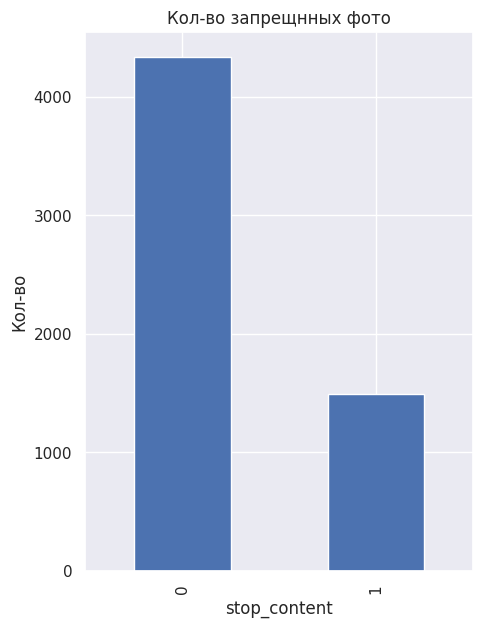

In [ ]:
df_train['stop_content'].value_counts().plot(kind='bar',
                                             title='Кол-во запрещнных фото',
                                             ylabel='Кол-во'
                                             );

Убираю запрещенный контент из обучающей выборки.

In [ ]:
df_train = df_train[df_train['stop_content']!=1]
df_train['stop_content'].unique()

array([0])

Провожу векторизацию текста

In [ ]:
tqdm.pandas()

# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# инициализация токенизатор, конфигурацию и модель BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model_emb_txt = transformers.BertModel.from_pretrained('bert-base-uncased', config=config).to(device)
# токенизируем текста
tokenized = df_train['query_text'].progress_apply(lambda x:
                                           tokenizer.encode(x, max_length=512,
                                                            truncation=True, add_special_tokens=True))

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 4332/4332 [00:01<00:00, 2938.36it/s]


In [ ]:
padded.shape[0] // 200

21

Формирую эмбеддинги

In [ ]:
dir = '/content/drive/MyDrive/ds_project5/train_images/'
try:
    # загрузка эмбеддингов из файла
    text_features = np.load(os.path.join(dir, 'text_vectors.npy'))
except:
    # создание эмбедингов
    batch_size = 200
    embeddings = []

    for i in notebook.tqdm(range(padded.shape[0] // batch_size  + 1)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
            attention_mask_batch = torch.Tensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

            with torch.no_grad():
                batch_embeddings = model_emb_txt(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    text_features = np.concatenate(embeddings)
    print(text_features.shape)
    # сохранение эмбеддингов в файл
    np.save(os.path.join(dir, 'text_vectors.npy'), text_features)

In [ ]:
# дополнение датасета эмбедингами
df_train['text_vectors'] = text_features.tolist()

Объединю таблицы df_exp_annot и df_train:

In [ ]:
df_exp_annot = df_exp_annot.sort_values(by='image').reset_index(drop=True)
df_train = df_train.sort_values(by='image').reset_index(drop=True)
df_train = df_train.join(df_exp_annot.loc[:,['grade1', 'grade2', 'grade3']], how='inner')
df_train.head()

,image,query_id,query_text,clear_text,lemm_text,stop_content,text_vectors,grade1,grade2,grade3
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,A man sleeps under a blanket on a city street,A man sleep under a blanket on a city street,0,"[0.2259453386068344, -0.1477699875831604, -0.4...",1,1,1
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,A woman plays with long red ribbons in an empt...,A woman play with long red ribbon in an empty ...,0,"[0.3637186288833618, 0.16300925612449646, -0.4...",1,1,2
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,Chinese market street in the winter time,Chinese market street in the winter time,0,"[-0.36842402815818787, -0.23577414453029633, -...",1,1,2
3,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,A man and woman look back at the camera while ...,A man and woman look back at the camera while ...,0,"[0.20837527513504028, 0.1989586353302002, 0.05...",1,2,2
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,A soccer ball is above the head of a man weari...,A soccer ball is above the head of a man weari...,A soccer ball be above the head of a man wear ...,0,"[-0.12382055819034576, 0.17725566029548645, -0...",1,1,2


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 0 to 4331
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         4332 non-null   object
 1   query_id      4332 non-null   object
 2   query_text    4332 non-null   object
 3   clear_text    4332 non-null   object
 4   lemm_text     4332 non-null   object
 5   stop_content  4332 non-null   int64 
 6   text_vectors  4332 non-null   object
 7   grade1        4332 non-null   int64 
 8   grade2        4332 non-null   int64 
 9   grade3        4332 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 372.3+ KB


Посчитаю новый признак - среднее значение оценки:

In [ ]:
def mean_grade(x):
    return np.mean([x['grade1'], x['grade2'], x['grade3']])
df_train['grade'] = df_train.apply(mean_grade, axis=1)
df_train.head()

,image,query_id,query_text,clear_text,lemm_text,stop_content,text_vectors,grade1,grade2,grade3,grade
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,A man sleeps under a blanket on a city street,A man sleep under a blanket on a city street,0,"[0.2259453386068344, -0.1477699875831604, -0.4...",1,1,1,1.000000
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,A woman plays with long red ribbons in an empt...,A woman play with long red ribbon in an empty ...,0,"[0.3637186288833618, 0.16300925612449646, -0.4...",1,1,2,1.333333
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,Chinese market street in the winter time,Chinese market street in the winter time,0,"[-0.36842402815818787, -0.23577414453029633, -...",1,1,2,1.333333
3,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,A man and woman look back at the camera while ...,A man and woman look back at the camera while ...,0,"[0.20837527513504028, 0.1989586353302002, 0.05...",1,2,2,1.666667
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,A soccer ball is above the head of a man weari...,A soccer ball is above the head of a man weari...,A soccer ball be above the head of a man wear ...,0,"[-0.12382055819034576, 0.17725566029548645, -0...",1,1,2,1.333333


Средняя оценка, переведенная в шкалу от 0 до 1 и будет целевым признаком.

In [ ]:
scaler = MinMaxScaler()
df_train['grade'] = scaler.fit_transform(df_train[['grade']])
df_train.head()

,image,query_id,query_text,clear_text,lemm_text,stop_content,text_vectors,grade1,grade2,grade3,grade
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,A man sleeps under a blanket on a city street,A man sleep under a blanket on a city street,0,"[0.2259453386068344, -0.1477699875831604, -0.4...",1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,A woman plays with long red ribbons in an empt...,A woman play with long red ribbon in an empty ...,0,"[0.3637186288833618, 0.16300925612449646, -0.4...",1,1,2,0.111111
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,Chinese market street in the winter time,Chinese market street in the winter time,0,"[-0.36842402815818787, -0.23577414453029633, -...",1,1,2,0.111111
3,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,A man and woman look back at the camera while ...,A man and woman look back at the camera while ...,0,"[0.20837527513504028, 0.1989586353302002, 0.05...",1,2,2,0.222222
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,A soccer ball is above the head of a man weari...,A soccer ball is above the head of a man weari...,A soccer ball be above the head of a man wear ...,0,"[-0.12382055819034576, 0.17725566029548645, -0...",1,1,2,0.111111


Уберу ненужные колонки из таблицы с данными

In [ ]:
df_train = df_train.loc[:,['image','text_vectors','grade']]
#df_train['words_vect'] = lemmed_text.tolist()
df_train.head()

,image,text_vectors,grade
0,1056338697_4f7d7ce270.jpg,"[0.2259453386068344, -0.1477699875831604, -0.4...",0.000000
1,1056338697_4f7d7ce270.jpg,"[0.3637186288833618, 0.16300925612449646, -0.4...",0.111111
2,1056338697_4f7d7ce270.jpg,"[-0.36842402815818787, -0.23577414453029633, -...",0.111111
3,1056338697_4f7d7ce270.jpg,"[0.20837527513504028, 0.1989586353302002, 0.05...",0.222222
4,1056338697_4f7d7ce270.jpg,"[-0.12382055819034576, 0.17725566029548645, -0...",0.111111


## Векторизация изображений

In [ ]:
resnet = models.resnet18(pretrained=True) #загружаем претренированную модель

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


Заморозка весов модели

In [ ]:
for param in resnet.parameters():
    param.requires_grad_(False)

Вывожу слои модели:

In [ ]:
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

Исключаю два последних слоя

In [ ]:
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to(device)

Перевод модели в режим предсказания:

In [ ]:
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Изменяю размер картинки, вырезаю центр и нормализую:

In [ ]:
#norm = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Загрузка кртинки и векторизация:

In [ ]:
pics = df_train['image'].unique()
try:
    # загрузка векторов из файла
    pict_vectors = np.load(os.path.join(dir, 'pictures_vectors.npy'))
    df_pict_vect = pd.DataFrame({'image': pics, 'img_vector': pict_vectors.tolist()})
except:
    pict_vect = []
    for pic in notebook.tqdm(pics):
        path = dir + pic
        #print(path)
        img = Image.open(path).convert('RGB')
        image_tensor = preprocess(img)
        image = Variable(image_tensor.unsqueeze(0)).to(device)
        output_tensor = resnet(image).cpu().flatten().numpy() # сразу спрямим тензор в вектор numpy
        pict_vect.append(output_tensor)
    # запилю векторы в файл
    pict_vectors = np.array(pict_vect)
    np.save(os.path.join(dir, 'pictures_vectors.npy'), pict_vectors)

Добавляю в обучающую выборку столбец с векторами изображений:

In [ ]:
# объединение векторов изображений с набором данных
df_train = df_train.merge(df_pict_vect, on='image', how='left')

In [ ]:
df_train.head(1)

,image,text_vectors,grade,img_vector
0,1056338697_4f7d7ce270.jpg,"[0.2259453386068344, -0.1477699875831604, -0.4...",0.0,"[0.6939404606819153, 3.0318355560302734, 2.916..."


## Проверка размерности векторов

Проверю размерности векторов

In [ ]:
for i in range(2):
    print(f'''
Размерность {i+1}-й пары:
text_vectors: {len(df_train.iloc[i][1])}
image_vector: {len(df_train.iloc[i][3])}
    ''')


Размерность 1-й пары:
text_vectors: 768
image_vector: 512
    

Размерность 2-й пары:
text_vectors: 768
image_vector: 512
    


/tmp/ipython-input-990857771.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text_vectors: {len(df_train.iloc[i][1])}
/tmp/ipython-input-990857771.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_vector: {len(df_train.iloc[i][3])}


Объединяю векторы признаков

In [ ]:
df_train['concatenated_vector'] = df_train.apply(lambda row: np.concatenate([row['text_vectors'],
                                                                             row['img_vector']], axis=None), axis=1)
print(f'Размерность объединенного вертора: {len(df_train.iloc[0][4])}')

Размерность объединенного вертора: 1280


/tmp/ipython-input-2935516862.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Размерность объединенного вертора: {len(df_train.iloc[0][4])}')


In [ ]:
pd.set_option('display.max_colwidth', 500)
df_train.head(1)

,image,text_vectors,grade,img_vector,concatenated_vector
0,1056338697_4f7d7ce270.jpg,"[0.2259453386068344, -0.1477699875831604, -0.4104270339012146, 0.00985676608979702, 0.024526314809918404, -0.012759887613356113, -0.16029542684555054, 1.2009299993515015, -0.40779033303260803, -0.553016185760498, -0.1869470775127411, -0.2232656031847, 0.10199423134326935, 0.5824909806251526, 0.4278459846973419, 0.2199062705039978, 0.3305620551109314, 0.6246508359909058, 0.3391376733779907, 0.09796358644962311, 0.28644368052482605, 0.23175156116485596, -0.18219974637031555, -0.116864435374736...",0.0,"[0.6939404606819153, 3.0318355560302734, 2.916933536529541, 0.9518980979919434, 0.9362950325012207, 1.2451164722442627, 0.8265243172645569, 1.1079425811767578, 0.16967923939228058, 0.36538252234458923, 0.25528421998023987, 1.4858478307724, 0.3072792589664459, 1.250614881515503, 0.04287335276603699, 0.8068845272064209, 0.9306020140647888, 0.6955927014350891, 0.2599792778491974, 1.6920057535171509, 0.3307254910469055, 0.8249002695083618, 2.285496711730957, 1.9401357173919678, 1.120828151702880...","[0.2259453386068344, -0.1477699875831604, -0.4104270339012146, 0.00985676608979702, 0.024526314809918404, -0.012759887613356113, -0.16029542684555054, 1.2009299993515015, -0.40779033303260803, -0.553016185760498, -0.1869470775127411, -0.2232656031847, 0.10199423134326935, 0.5824909806251526, 0.4278459846973419, 0.2199062705039978, 0.3305620551109314, 0.6246508359909058, 0.3391376733779907, 0.09796358644962311, 0.28644368052482605, 0.23175156116485596, -0.18219974637031555, -0.116864435374736..."


In [ ]:
X_train = df_train['concatenated_vector'].apply(pd.Series)
y_train = df_train['grade']

In [ ]:
X_train.shape

(4332, 1280)

Данные модели готовы для обучения.

Удаляю лишние переменные:

In [ ]:
%who_ls

['CountVectorizer',
 'DecisionTreeRegressor',
 'GridSearchCV',
 'Image',
 'KNeighborsClassifier',
 'LETTERS',
 'LinearRegression',
 'MinMaxScaler',
 'Pipeline',
 'RANDOM_STATE',
 'RandomizedSearchCV',
 'SPACES',
 'TfidfVectorizer',
 'Variable',
 'WordNetLemmatizer',
 'X_train',
 'attention_mask',
 'ceil',
 'clear_text',
 'col',
 'color',
 'config',
 'cv2',
 'device',
 'df_crwd_annot',
 'df_exp_annot',
 'df_pict_vect',
 'df_test_img',
 'df_test_query',
 'df_train',
 'dir',
 'drive',
 'elm',
 'f',
 'filter_words',
 'get_wordnet_pos',
 'i',
 'isfile',
 'lemmatize',
 'listdir',
 'mean_grade',
 'model_emb_txt',
 'models',
 'modules',
 'nltk',
 'nltk_stopwords',
 'nn',
 'notebook',
 'np',
 'onlyfiles_train',
 'os',
 'pad_sequence',
 'padded',
 'param',
 'pd',
 'pics',
 'pict_vectors',
 'plt',
 'preprocess',
 're',
 'resnet',
 'root_mean_squared_error',
 'scaler',
 'sns',
 'stop_list',
 'text_features',
 'tokenized',
 'tokenizer',
 'torch',
 'tqdm',
 'train_test_split',
 'transformers',
 'tra

In [ ]:
#del attention_mask, config, device, df_train, grid_srch_LR, isfile, lemmatize, listdir, mean_grade, nltk, nltk_stopwords, num_epoch, onlyfiles_train, pad_sequence, padded, pics, pict_vectors, preprocess, re, resnet, scaler, stop_list, stopwords, text_features, tokenized, tokenizer, tqdm, transformers, transforms, word_tokenize, wordnet

# Создание моделей машинного обучения

Согласно заданию нужно обучить несколько моделей и подбрать их гиперпараметры. В качестве моделей обязательно нужно рассмотреть:
1. Линейную регрессию;
2. Полносвязные нейронные сети.

Также будет рассмотрена регриссионная модель дерева решений.
<br>В качестве метрики будет использована RSME.

In [ ]:
pipe_final = Pipeline(
    [
        ('models', LinearRegression())
    ]
)

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train,
                                              y_train,
                                              test_size=0.25,
                                              random_state=RANDOM_STATE
                                              )

## Модель линейной регрессии

In [ ]:
model_LR = LinearRegression()
model_LR.fit(X_trn, y_trn)
y_pred = model_LR.predict(X_val)

Метрика качества модели составляет:

In [ ]:
rmse = root_mean_squared_error(y_val, y_pred)
print(f'Метрика качества RSME модели на валидационной выборке составляет: {rmse:0.3}')

Метрика качества RSME модели на валидационной выборке составляет: 0.337


## Модель дерева решений

In [ ]:
param_distr_DTR = [
    {
        'models': [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_leaf': range(1, 16),
        'models__min_samples_split': range(2, 16)
    }
     ]

In [ ]:
rand_srch_DTR = RandomizedSearchCV(
    pipe_final,
    param_distr_DTR,
    cv = 5,
    scoring='neg_mean_squared_error',
    random_state = RANDOM_STATE,
    n_jobs=-1,
)

In [ ]:
rand_srch_DTR.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=2025)],
                                         'models__max_depth': range(2, 11),
                                         'models__min_samples_leaf': range(1, 16),
                                         'models__min_samples_split': range(2, 16)}],
                   random_state=2025, scoring='neg_mean_squared_error')

In [ ]:
pd.set_option('display.max_columns', 500)
result_DTR = pd.DataFrame(rand_srch_DTR.cv_results_)
result_DTR[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
7,1,DecisionTreeRegressor(random_state=2025),-0.075546,"{'models__min_samples_split': 8, 'models__min_samples_leaf': 12, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=2025)}"
5,2,DecisionTreeRegressor(random_state=2025),-0.076919,"{'models__min_samples_split': 3, 'models__min_samples_leaf': 9, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=2025)}"
0,3,DecisionTreeRegressor(random_state=2025),-0.078108,"{'models__min_samples_split': 2, 'models__min_samples_leaf': 12, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=2025)}"
2,4,DecisionTreeRegressor(random_state=2025),-0.083656,"{'models__min_samples_split': 10, 'models__min_samples_leaf': 2, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=2025)}"
6,5,DecisionTreeRegressor(random_state=2025),-0.084189,"{'models__min_samples_split': 5, 'models__min_samples_leaf': 14, 'models__max_depth': 7, 'models': DecisionTreeRegressor(random_state=2025)}"
3,6,DecisionTreeRegressor(random_state=2025),-0.088014,"{'models__min_samples_split': 4, 'models__min_samples_leaf': 11, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=2025)}"
9,7,DecisionTreeRegressor(random_state=2025),-0.090993,"{'models__min_samples_split': 13, 'models__min_samples_leaf': 3, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=2025)}"
8,8,DecisionTreeRegressor(random_state=2025),-0.091948,"{'models__min_samples_split': 10, 'models__min_samples_leaf': 10, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=2025)}"
4,9,DecisionTreeRegressor(random_state=2025),-0.092789,"{'models__min_samples_split': 4, 'models__min_samples_leaf': 5, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=2025)}"
1,10,DecisionTreeRegressor(random_state=2025),-0.094506,"{'models__min_samples_split': 10, 'models__min_samples_leaf': 6, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=2025)}"


## Модель полносвязной нейронной сети

In [ ]:
n_in_neurons = len(X_train.columns) # определяю число входных признаков первого (входного) слоя модели
X_trn = torch.FloatTensor(X_trn.values)
X_val = torch.FloatTensor(X_val.values)
y_trn = torch.FloatTensor(y_trn.values)
y_val = torch.FloatTensor(y_val.values)

In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.2, inplace=False)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.4, inplace=False)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.Tanh()
        self.do3 = nn.Dropout(p=0.4, inplace=False)

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = nn.Tanh()
        self.do4 = nn.Dropout(p=0.4, inplace=False)

        self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.do1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.do2(x)

        x = self.fc3(x)
        x = self.act3(x)
        x = self.do3(x)

        x = self.fc4(x)
        x = self.act4(x)
        x = self.do4(x)

        x = self.fc5(x)
        return x

In [ ]:
n_hidden_neurons_1 = 1024
n_hidden_neurons_2 = 512
n_hidden_neurons_3 = 256
n_hidden_neurons_4 = 128
n_out_neurons = 1
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)

Net(
  (fc1): Linear(in_features=1280, out_features=1024, bias=True)
  (act1): ReLU()
  (do1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (act2): ReLU()
  (do2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (act3): Tanh()
  (do3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (act4): Tanh()
  (do4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
)


Создаю функцию для расчета метрики качества

In [ ]:
def rmse_loss(output, target):
    return torch.sqrt(nn.MSELoss()(output, target))

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear: # Проверка, что слой — полносвязный
        nn.init.normal_(layer.weight, mean=0.5, std=0.5)
        nn.init.normal_(layer.bias, mean=-0.5, std=1.5)

In [ ]:
net.apply(init_weights)

Net(
  (fc1): Linear(in_features=1280, out_features=1024, bias=True)
  (act1): ReLU()
  (do1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (act2): ReLU()
  (do2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (act3): Tanh()
  (do3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (act4): Tanh()
  (do4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
def net_train(model, X, y, batch_size, regul=None):
    # на вход функции подается следующее:
    # model - модель нейронной сети, которая будет обучаться (объект)
    # X - признаки из тренировочной выборки
    # y - целевой признак из тренировочной выборки
    # batch_size - количество батчей
    # regul - способ регуляроизации модели (по умолчанию l1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_batches = ceil(len(X)/batch_size)
    order = np.random.permutation(len(X)) # генерируется случайная перестановка чисел от 0 до размера обучающей выборки
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size # индекс батча
        optimizer.zero_grad() # обнуление накопленного градиента
        # получение индексов текущего батча
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X[batch_indexes]
        y_batch = y[batch_indexes]
        pred = model.forward(X).flatten()
        if regul == 'l1':
            l1_lambda = 0.01
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = rmse_loss(pred, y) + l1_lambda * l1_norm
        elif regul == 'l2':
            l2_lambda = 0.01
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = rmse_loss(pred, y) + l2_lambda * l2_norm
        else:
            loss = rmse_loss(pred, y)
            #print('Regulization function is not set')
        loss.backward() # расчет градиента функции потерь
        optimizer.step() # метод, обновляющий веса модели
    pass #return model

In [ ]:
def net_test(model, X, y, ep, prt='y'):
    # на вход функции подается следующее:
    # model - модель нейронной сети, которая будет теститься (объект)
    # X - признаки из тестовой выборки
    # y - целевой признак из тестовой выборки
    # ep - номер эпохи
    model.eval()
    test_pred = model.forward(X).flatten()
    loss = rmse_loss(test_pred, y)
    if prt == 'y':
        print(f"epoch # {ep}: {loss}")
    return test_pred, loss.item()

In [ ]:
def model_learn_test(model, X_train, y_train, X_test, y_test, num_epoch, batch_size, regul, goal, prt):
    # goal - целевое значение метрики качества
    # prt - вывод на экран промежуточных значений
    # функция для обучения и тестирования нейросети
    for epoch in range(1, num_epoch + 1):
        net_train(model, X_train, y_train, batch_size, regul)
        # проводим прогон модели на тестовых данных каждую 1000-ую эпоху
        if epoch % 10 == 0:
            test_pred, rmse = net_test(model, X_test, y_test, epoch, prt)
            if rmse < goal:
                break
            else:
                continue
    return model, test_pred, rmse

In [ ]:
num_epoch = 100
b_size = 100

In [ ]:
%%time
net, test_pred, rmse = model_learn_test(net, X_trn, y_trn, X_val, y_val, num_epoch, b_size, None, 0.07, 'y')
print(f'Конечная метрика rmse составляет: {rmse}')
print(f'Архитектура модели: \n {net}')

epoch # 10: 33.738101959228516
epoch # 20: 0.2782049775123596
epoch # 30: 0.27811527252197266
epoch # 40: 0.27817344665527344
epoch # 50: 0.2781160771846771
epoch # 60: 0.27820247411727905
epoch # 70: 0.27810198068618774
epoch # 80: 0.2782340943813324
epoch # 90: 0.2781188189983368
epoch # 100: 0.278103768825531
Конечная метрика rmse составляет: 0.278103768825531
Архитектура модели: 
 Net(
  (fc1): Linear(in_features=1280, out_features=1024, bias=True)
  (act1): ReLU()
  (do1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (act2): ReLU()
  (do2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (act3): Tanh()
  (do3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (act4): Tanh()
  (do4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
)
CPU times: user 34min 41s, sys: 4.72 s, total: 34min 46s
Wall time: 35

Лучшей моделью оказалась DecisionTreesRegression с метрикой 0.07 на валидационной выборке.

# Проверка лучшей модели на тестовых данных

In [ ]:
df_test_query.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [ ]:
df_test_query['clear_text'] = df_test_query['query_text'].progress_apply(clear_text)
df_test_query['lemm_text'] = df_test_query['clear_text'].progress_apply(lemmatize)

100%|██████████| 500/500 [00:00<00:00, 741.11it/s]


In [ ]:
df_test_query['stop_content'] = df_test_query['lemm_text'].apply(filter_words)
df_test_query = df_test_query[df_test_query['stop_content']!=1]
df_test_query.head()

,query_id,query_text,image,clear_text,lemm_text,stop_content
10,123997871_6a9ca987b1.jpg#0,Girls wearing sports uniforms and eye protection .,123997871_6a9ca987b1.jpg,Girls wearing sports uniforms and eye protection,Girls wear sport uniform and eye protection,0
11,123997871_6a9ca987b1.jpg#1,Several female lacrosse players are going after a ball .,123997871_6a9ca987b1.jpg,Several female lacrosse players are going after a ball,Several female lacrosse player be go after a ball,0
13,123997871_6a9ca987b1.jpg#3,The woman lacrosse player in blue is about to catch the ball .,123997871_6a9ca987b1.jpg,The woman lacrosse player in blue is about to catch the ball,The woman lacrosse player in blue be about to catch the ball,0
14,123997871_6a9ca987b1.jpg#4,Women play lacrosse .,123997871_6a9ca987b1.jpg,Women play lacrosse,Women play lacrosse,0
15,1319634306_816f21677f.jpg#0,A brown dog is sitting in some long grass .,1319634306_816f21677f.jpg,A brown dog is sitting in some long grass,A brown dog be sit in some long grass,0


In [ ]:
tokenized = df_test_query['query_text'].progress_apply(lambda x:
                                           tokenizer.encode(x, max_length=512,
                                                            truncation=True, add_special_tokens=True))

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

100%|██████████| 341/341 [00:00<00:00, 1775.23it/s]


In [ ]:
dir = '/content/drive/MyDrive/ds_project5/test_images/'
try:
    # загрузка эмбеддингов из файла
    text_features = np.load(os.path.join(dir, 'text_vectors.npy'))
except:
    # создание эмбедингов
    batch_size = 200
    embeddings = []

    for i in notebook.tqdm(range(padded.shape[0] // batch_size  + 1)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
            attention_mask_batch = torch.Tensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

            with torch.no_grad():
                batch_embeddings = model_emb_txt(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    text_features = np.concatenate(embeddings)
    print(text_features.shape)
    # сохранение эмбеддингов в файл
    np.save(os.path.join(dir, 'text_vectors.npy'), text_features)

In [ ]:
pics = df_test_query['image'].unique()
try:
    # загрузка векторов из файла
    pict_vectors = np.load(os.path.join(dir, 'pictures_vectors.npy'))
    df_pict_vect = pd.DataFrame({'image': pics, 'img_vector': pict_vectors.tolist()})
except:
    pict_vect = []
    for pic in notebook.tqdm(pics):
        path = dir + pic
        #print(path)
        img = Image.open(path).convert('RGB')
        image_tensor = preprocess(img)
        image = Variable(image_tensor.unsqueeze(0)).to(device)
        output_tensor = resnet(image).cpu().flatten().numpy() # сразу спрямим тензор в вектор numpy
        pict_vect.append(output_tensor)
    # запилю векторы в файл
    pict_vectors = np.array(pict_vect)
    np.save(os.path.join(dir, 'pictures_vectors.npy'), pict_vectors)

In [ ]:
# объединение векторов изображений с набором данных
df_test = df_test_query.merge(df_pict_vect, on='image', how='left')
df_test['text_vectors'] = text_features.tolist()
df_test['concatenated_vector'] = df_test.apply(lambda row: np.concatenate([row['text_vectors'],
                                                                             row['img_vector']], axis=None), axis=1)

In [ ]:
X_test = df_test['concatenated_vector'].apply(pd.Series)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.366310,-0.131031,-0.791171,0.159633,-0.296238,0.066132,0.377505,0.529201,-0.439411,-0.232075,-0.510276,-0.086401,-0.652124,0.373860,-0.212631,0.314966,-0.451638,0.791945,-0.020650,0.073122,-0.076001,-0.161941,-0.314614,-0.075045,0.428810,-0.407198,0.519733,0.251283,-0.316753,0.346760,0.235842,-0.116120,-0.025955,0.154112,0.264593,-0.850861,0.441803,-0.085162,0.189424,0.050402,-0.317945,-0.010768,0.082349,-0.349520,0.210702,-0.493804,-2.254599,0.396084,-0.129350,-0.391890,-0.217296,0.110572,0.559032,0.623993,0.467823,0.542318,-0.497645,0.125327,0.611591,-0.267694,0.632840,-0.066674,-0.363017,-0.239441,0.196160,0.031480,0.112972,0.136510,-0.246358,-0.297093,-0.929983,-0.366333,0.268843,-1.156188,0.297398,-0.170777,0.372081,0.209694,-0.444754,-0.687998,-0.028796,0.382010,0.013395,0.474709,-0.185622,0.203135,-0.253062,-0.858578,0.336619,0.958029,0.063227,0.219610,1.050115,0.575793,0.073557,0.742280,0.274431,-0.048799,0.662315,-0.414482,-0.273846,0.013313,0.243783,-0.306020,-0.154106,0.106638,0.267665,-0.307471,-0.018959,-1.731012,0.298467,-0.552405,0.049183,0.192922,-0.406783,0.930361,0.034300,-0.014590,-0.373046,-0.035886,-0.284277,0.024459,0.009496,0.316013,-0.044250,0.473589,0.111246,0.268816,0.281561,-0.112326,0.588901,0.824548,-0.305167,-0.126972,-0.077570,-0.340291,0.526586,-0.251642,-0.012470,-0.564049,-0.615949,-0.628935,-2.083652,-0.724253,0.742190,-0.608192,0.303058,0.265348,-0.087149,0.387600,0.246340,0.048168,-0.035897,-0.330410,0.112439,-0.003625,-0.428842,-0.513576,0.234281,0.393632,0.353026,-0.295642,-0.671977,0.261654,-0.118509,0.187429,-0.090901,0.362787,0.094734,0.942872,-0.142284,0.017464,0.410406,0.018678,0.084196,0.123752,0.052045,0.766110,0.438043,0.011238,-0.300606,0.968622,0.723943,0.094882,0.010730,-0.575620,0.017859,-0.199816,-0.466054,-0.377607,0.111458,-0.323632,0.229185,0.481373,0.030877,-0.348

In [ ]:
best_model = rand_srch_DTR

In [ ]:
y_pred = best_model.predict(X_test)

Предполагается, что тестовая выборка имеет полное соответствие описания картинкам.

In [ ]:
y_test = np.ones(y_pred.shape)

In [ ]:
rmse_test = root_mean_squared_error(y_test, y_pred)
print(f'Метрика качества RSME модели на валидационной выборке составляет: {rmse_test:0.3}')

Метрика качества RSME модели на валидационной выборке составляет: 0.781


Качество на тестовой выборке низкое и можно объяснить это плохими данным, в которых большая часть изображений не соответствует описанию.

#Функция для вывода изображений по запросу

Согласно заданию нужно написать функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

Общая идея:
1) векторизовать текст запроса;
2) найти ближайший вектор текста запроса из выборки, причем в этой выборке соответствие запроса и картинки будет более 80%;
3) проделать шаг 2 ещё 4 раза, чтобы отобрать несколько картинок
4) определить максимальное значение целевого признака из 5 выбранных - это будет y_true, а соответствующая картинка должна быть выведена на экран.
5) для вектора этой картинки и вектора введенного пользователем описания определить значение целевого признака по лучшей модели - y_pred;
6) вычислить метрику качества rsme.

In [ ]:
# улучшу ситуацию с данными, отобрав из них те, для которых избражение больше соответствует описанию
cond = df_train['grade'] > 0.8
X_train_KNN = df_train[cond]['text_vectors'].apply(pd.Series)
y_train_KNN = pd.DataFrame(np.array(df_train[cond]['text_vectors'].index))

In [ ]:
df_train[cond]['grade'].head()

,grade
43,1.000000
50,0.888889
53,1.000000
70,1.000000
85,1.000000


In [ ]:
X_train_KNN.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
43,0.240974,0.425232,-0.143750,-0.181163,0.141571,-0.166517,0.100569,0.543813,-0.236660,-0.478184,-0.031452,0.046115,0.396269,0.488161,0.587505,-0.075042,-0.206386,0.710028,0.216634,-0.463773,0.035196,-0.454820,-0.066252,-0.401094,-0.097953,0.437287,0.049490,0.203751,0.118978,0.073066,-0.228886,0.159248,-0.338453,-0.193895,0.523371,-0.093154,0.252060,0.179898,0.053282,0.442800,-0.218010,-0.393869,0.114814,-0.335897,0.242692,-1.016643,-1.974389,0.233148,-0.008514,0.027647,-0.309028,0.001878,0.114861,0.466227,-0.222392,0.532205,0.096506,0.233881,0.127734,0.267857,0.455730,0.191409,0.048509,-0.264017,-0.211592,0.148100,-0.347281,0.123251,0.053181,0.005187,-0.659767,-0.003895,0.011833,-0.588618,0.005316,-0.199429,0.185150,0.625470,-0.055110,-0.972676,0.304895,0.661024,0.090143,0.547836,0.500115,-0.454673,-0.530181,-0.333255,-0.009677,0.086594,-0.394025,0.116149,-0.119671,1.120770,-0.151592,0.274165,0.254904,0.074205,0.251206,0.088845,0.431980,0.352462,0.674145,-0.426488,0.495563,0.074092,0.222998,-0.237575,0.141912,-2.139402,-0.049209,-0.545417,0.197484,0.129516,-0.304460,0.051015,-0.266563,-0.084263,-0.653997,-0.066190,0.379889,-0.472603,-0.472084,-0.395403,-0.320029,-0.019551,0.095121,0.073684,0.305165,0.017526,0.324952,0.844580,-0.117322,-0.566007,0.135751,-0.104561,0.705645,-0.405032,-0.072390,-0.668503,-0.349945,0.082920,-2.648776,0.464504,1.070313,0.126721,-0.291451,0.077646,0.090338,0.341885,-0.368251,-0.068281,0.343417,0.046204,-0.009605,0.117284,0.085834,-0.391280,0.649691,0.259065,0.145301,-0.360008,0.173150,-0.657143,-0.076009,0.312541,0.793958,0.055748,-0.754713,0.030685,-0.442606,0.351711,-0.033896,0.105087,0.668914,0.037242,-0.050629,0.809168,0.122930,-0.211513,-0.223775,0.420443,0.719347,-0.095635,-0.038620,-0.016587,0.596183,0.086970,-0.372308,-0.099129,0.055381,-0.136869,-0.166278,0.078887,-0.197069,-0.629542,0.261785,-0.954996,-0.103360,0.385275,-0.562946,-0.309248,-0.137642,-0.046517,-0.076092,3.592560,0.127240,-0.263839,-0.162084,0.024756,-0.644312,0.009904,-0.090167,0.466260,0.113880,-0.204905,0.059139,0.308843,0.016719,0.180478,0.237186,0.492040,-0.91

In [ ]:
len(X_train_KNN)

240

In [ ]:
y_train_KNN.head()

,0
0,43
1,50
2,53
3,70
4,85


Для отбора похожих по запросу в базе изображений создаю модель KNN, которая должна выдавать индексы строк обучающей выборки.

In [ ]:
model_KNN = KNeighborsClassifier(1)
model_KNN.fit(X_train_KNN, y_train_KNN)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=1)

In [ ]:
X_train_KNN = df_train[cond]['text_vectors'].apply(pd.Series)
def get_text_vector(query_text):
    # токенизируем текст
    tokenized = tokenizer.encode(query_text, max_length=512, truncation=True, add_special_tokens=True)
    padded = pad_sequence([torch.as_tensor(tokenized)], batch_first=True)

    # маска внимания
    attention_mask = padded > 0
    attention_mask = attention_mask.type(torch.LongTensor).to(device)

    # эмбеддинги
    with torch.no_grad():
        text_embedding = model_emb_txt(padded.to(device), attention_mask=attention_mask)[0][:, 0, :].cpu().numpy()

    return text_embedding[0].tolist()

def nearest_vector(query_text, X_trn, y_trn):
    # функция возвращает список индексов из выборки, имеющими близкое к запросу описание
    df_query = pd.DataFrame(columns = range(len(X_trn.columns)))
    df_query.loc[0] = get_text_vector(query_text)
    index_pred = []
    # ищу 5 близких по описанию соседних вектора
    for i in range(5):
        ind_val = int(model_KNN.predict(df_query)[0])
        index_pred.append(ind_val)
        #print('index_pred =', index_pred)
        #print(X_trn.index)
        #print(y_trn.index)
        X_trn['number'] = range(len(X_trn))
        #print(X_trn.head())
        ind_val_y = X_trn['number'].loc[ind_val]
        #print(ind_val_y)
        X_trn = X_trn.drop(ind_val)
        X_trn = X_trn.drop('number', axis=1)
        y_trn = y_trn.drop(ind_val_y).reset_index(drop=True)
        model_KNN.fit(X_trn, y_trn)
    try:
        X_trn = X_trn.drop('number', axis=1)
    except:
        pass
    return index_pred

def display_image_by_query(query_text, dir, df=df_train, X_trn=X_train_KNN, y_trn=y_train_KNN):
    text = clear_text(query_text)
    if any(i in text for i in stop_list):
        print(query_text)
        print('Изображение не доступно в данном регионе по юридическим ограничениям')
    else:
        # определение ближайшего вектора
        indx = nearest_vector(query_text, X_trn, y_trn)
        # определение имя файла картинки по запросу
        #y_pred_bm = pd.DataFrame(best_model.predict(X_train.loc[indx]), index=[indx])
        df_y_true = df_train[['image','img_vector','grade']].loc[indx]
        #print('df_y_true', df_y_true)
        y_true = df_y_true['grade'].max()
        y_true_idx = df_y_true['grade'].idxmax()
        #print(y_true_idx)
        best_image = df_y_true['image'].loc[y_true_idx]
        #print(best_image)
        img_path = os.path.join(dir, best_image)
        #print(img_path)
        print('Модель показала лучшую величину соответствия для этого изображения:')
        fig, ax = plt.subplots(figsize=(6, 6))
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(query_text, fontsize=12)
        ax.axis('off')
        plt.show()
        df_query = pd.DataFrame(columns = ['text_vectors', 'img_vector'])
        df_query.loc[0] = [get_text_vector(query_text), df_y_true['img_vector'].loc[y_true_idx]]
        #print(df_query)
        df_query['concatenated_vector'] = df_query.apply(lambda row: np.concatenate([row['text_vectors'],
                                                                             row['img_vector']], axis=None), axis=1)
        X_query = df_query['concatenated_vector'].apply(pd.Series)
        #print(X_query)
        y_pred = best_model.predict(X_query)
        rmse_query = root_mean_squared_error([y_true], y_pred)
        print(f'Мера соответствия изображения составляет: {rmse_query:0.2f}')

Проверяю функцию поиска ближайших в выборке "соседей" по запросу:

In [ ]:
#query_test = 'A man sleeps under a blanket on a city street.'
#index_val = nearest_vector(query_test, X_train_KNN, y_train_KNN)
#print(index_val)

На выходе получены 5 индексов, как и ожидалось. Функция работает нормально.

Проверка работы функции:

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Модель показала лучшую величину соответствия для этого изображения:


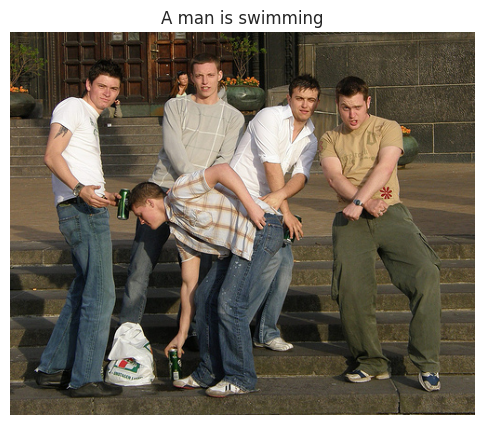

Мера соответствия изображения составляет: 0.78


In [ ]:
dir_for_search = '/content/drive/MyDrive/ds_project5/train_images/'
display_image_by_query('A man is swimming', dir_for_search, df_train)
X_train_KNN = df_train[cond]['text_vectors'].apply(pd.Series)

# Заключение

Опишите модель, которая лучше всего справляется с задачей сравнения сходства картинки и текста. Опишите, какие ошибки допускает модель во время поиска картинки по её текстовому описанию. Оцените, насколько проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим.

Для оценки степени соответствия фотографиям и описанию была создана модель машинного обучения на основе данных фотографий, описаний и оценки экспертов.
<br> В ходе создания было рассмотренно несколько моделей ML, среди которых были линейная регрессия, древесная модель и модель полносвязанной нейронной сети.
<br> Лучшей моделью при валидации оказалась древесная модель.
<br> Стоит отметить, что в обучающей выборке большинство фото не соответствовало описанию, что оказывает существенное влияние на модель и метрика качества на тестовой выборке получилась значительно хуже, чем на валидационной.